In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
import os

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


In [6]:
# Download the train and test dataset
# California housing dataset: https://developers.google.com/machine-learning/crash-course/california-housing-data-description
# Train set: https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv
# Test set: https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [7]:
train_path = r'/content/gdrive/MyDrive/Colab Notebooks/califronia_housing_train.csv'
test_path = r'/content/gdrive/MyDrive/Colab Notebooks/califronia_housing_test.csv'


In [8]:
train_df = pd.read_csv(r"/content/gdrive/MyDrive/Colab Notebooks/california_housing_train.csv", delimiter=",")
test_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/california_housing_test.csv", delimiter=",")


In [9]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0
...,...,...,...,...,...,...,...,...,...
16995,-124.3,40.6,52.0,2217.0,394.0,907.0,369.0,2.4,111400.0
16996,-124.3,40.7,36.0,2349.0,528.0,1194.0,465.0,2.5,79000.0
16997,-124.3,41.8,17.0,2677.0,531.0,1244.0,456.0,3.0,103600.0
16998,-124.3,41.8,19.0,2672.0,552.0,1298.0,478.0,2.0,85800.0


In [10]:
test_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.0,37.4,27.0,3885.0,661.0,1537.0,606.0,6.6,344700.0
1,-118.3,34.3,43.0,1510.0,310.0,809.0,277.0,3.6,176500.0
2,-117.8,33.8,27.0,3589.0,507.0,1484.0,495.0,5.8,270500.0
3,-118.4,33.8,28.0,67.0,15.0,49.0,11.0,6.1,330000.0
4,-119.7,36.3,19.0,1241.0,244.0,850.0,237.0,2.9,81700.0
...,...,...,...,...,...,...,...,...,...
2995,-119.9,34.4,23.0,1450.0,642.0,1258.0,607.0,1.2,225000.0
2996,-118.1,34.1,27.0,5257.0,1082.0,3496.0,1036.0,3.4,237200.0
2997,-119.7,36.3,10.0,956.0,201.0,693.0,220.0,2.3,62000.0
2998,-117.1,34.1,40.0,96.0,14.0,46.0,14.0,3.3,162500.0


# Data Processing: Normalize values
When building a model with multiple features, the values of each feature should cover roughly the same range. The following code cell normalizes datasets by converting each raw value to its Z-score.


In [11]:
#@title Convert raw values to their Z-scores 

# Calculate the Z-scores of each column in the training set:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

print("Normalized the values.")

Normalized the values.


# Preparing Dataset for Training

The following code cell creates a feature layer containing three features:

latitude X longitude (a feature cross)



median_income
population
This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in my_feature_layer) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model.

In [12]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# We scaled all the columns, including latitude and longitude, into their
# Z scores. So, instead of picking a resolution in degrees, we're going
# to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)  

# Represent median_income as a floating-point value.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as a floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Build a linear regression model as a baseline
Before creating a deep neural net, find a baseline loss by running a simple linear regression model that uses the feature layer you just created.

In [13]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [14]:
#@title Define functions to create and train a linear regression model
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model           

In [15]:
def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Run the following code cell to invoke the functions defined in the preceding  two code cells. (Ignore the warning messages.)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/15


17/17 [==============================] - 1s 4ms/step - loss: 0.8589 - mean_squared_error: 0.8589
Epoch 2/15
17/17 [==============================] - 0s 4ms/step - loss: 0.5793 - mean_squared_error: 0.5793
Epoch 3/15
17/17 [==============================] - 0s 3ms/step - loss: 0.4509 - mean_squared_error: 0.4509
Epoch 4/15
17/17 [==============================] - 0s 3ms/step - loss: 0.3884 - mean_squared_error: 0.3884
Epoch 5/15
17/17 [==============================] - 0s 4ms/step - loss: 0.3658 - mean_squared_error: 0.3658
Epoch 6/15
17/17 [==============================] - 0s 3ms/step - loss: 0.3612 - mean_squared_error: 0.3612
Epoch 7/15
17/17 [==============================] - 0s 4ms/step - loss: 0.3607 - mean_squared_error: 0.3607
Epoch 8/15
17/17 [==============================] - 0s 4ms/step - loss: 0.3601 - mean_squared_error: 0.3601
Epoch 9/15
17/17 [==============================] - 0s 3ms/step - loss: 0.3603 - mean_squared_error: 0.3603
Epoch 10/15
17/17 [====================

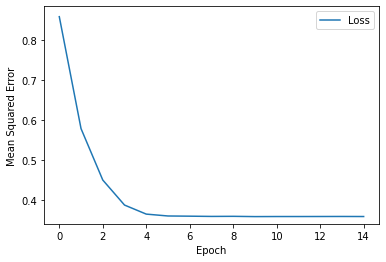


 Evaluate the linear regression model against the test set:
3/3 [==============================] - 0s 7ms/step - loss: 0.3944 - mean_squared_error: 0.3944


[0.39441072940826416, 0.39441072940826416]

In [16]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

# Exercise: Train a deep neural network 

*   Build a newural network with 2 hidden layers
*   Experiment with the same learning rate as the linear regression model earlier and compare the results
*   Experiment with a different learning rates with a deep net and compare the results
*   Bonus: Experiment with different number of perceptrons in each layer







# HIDDEN FROM STUDENTS

## Define a deep neural net model

The `create_model` function defines the topography of the deep neural net, specifying the following:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.

The `create_model` function also defines the [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) of each layer.

In [17]:
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # Define the second hidden layer with 12 nodes. 
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

In [18]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


17/17 [==============================] - 1s 5ms/step - loss: 0.5779 - mean_squared_error: 0.5779
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3682 - mean_squared_error: 0.3682
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.3455 - mean_squared_error: 0.3455
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3386 - mean_squared_error: 0.3386
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3387 - mean_squared_error: 0.3387
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3356 - mean_squared_error: 0.3356
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3361 - mean_squared_error: 0.3361
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3351 - mean_squared_error: 0.3351
Epoch 9/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3328 - mean_squared_error: 0.3328
Epoch 10/20
17/17 [====================

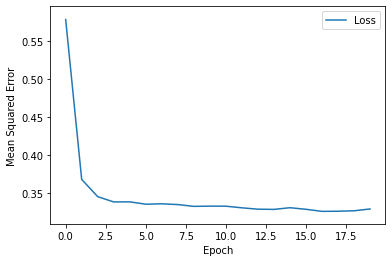


 Evaluate the new model against the test set:
3/3 [==============================] - 0s 8ms/step - loss: 0.3709 - mean_squared_error: 0.3709


[0.3708657920360565, 0.3708657920360565]

In [19]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

In [20]:

# Assuming that the linear model converged and
# the deep neural net model also converged, please 
# compare the test set loss for each.
# In our experiments, the loss of the deep neural 
# network model was consistently lower than 
# that of the linear regression model, which 
# suggests that the deep neural network model 
# will make better predictions than the 
# linear regression model.

# You may noticed the following trends:
* Two layers outperformed one layer, but 
three layers did not perform significantly 
     better than two layers; two layers 
     outperformed one layer.
     In other words, two layers seemed best. 
* Setting the topography as follows produced 
     reasonably good results with relatively few 
     nodes:
    * 10 nodes in the first layer.
    *  6 nodes in the second layer.

As the number of nodes in each layer dropped
below the preceding, test loss increased.  
However, depending on your application, hardware
constraints, and the relative pain inflicted 
by a less accurate model, a smaller network 
(for example, 6 nodes in the first layer and 
4 nodes in the second layer) might be 
acceptable.

# Addressing the Overfitting Problem  

## Regularize the deep neural network (if you have enough time)

Notice that the model's loss against the test set is *much higher* than the loss against the training set.  In other words, the deep neural network is [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) to the data in the training set.  To reduce overfitting, regularize the model.  There several different ways to regularize a model, including:

  * [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization)
  * [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization)
  * [Dropout regularization](https://developers.google.com/machine-learning/glossary/#dropout_regularization)

Your task is to experiment with one or more regularization mechanisms to bring the test loss closer to the training loss (while still keeping test loss relatively low).  

**Note:** When you add a regularization function to a model, you might need to tweak other hyperparameters. 

### Implementing L1 or L2 regularization

To use L1 or L2 regularization on a hidden layer, specify the `kernel_regularizer` argument to [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). Assign one of the following methods to this argument:

* `tf.keras.regularizers.l1` for L1 regularization
* `tf.keras.regularizers.l2` for L2 regularization

Each of the preceding methods takes an `l` parameter, which adjusts the [regularization rate](https://developers.google.com/machine-learning/glossary/#regularization_rate). Assign a decimal value between 0 and 1.0 to `l`; the higher the decimal, the greater the regularization. For example, the following applies L2 regularization at a strength of 0.01. 

```
model.add(tf.keras.layers.Dense(units=20, 
                                activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                name='Hidden1'))
```

### Implementing Dropout regularization

You implement dropout regularization as a separate layer in the topography. You implement dropout regularization as a separate layer in the topography. For example, the following code demonstrates how to add a dropout regularization layer between the first hidden layer and the second hidden layer:

```
model.add(tf.keras.layers.Dense( *define first hidden layer*)
 
model.add(tf.keras.layers.Dropout(rate=0.25))

model.add(tf.keras.layers.Dense( *define second hidden layer*)
```

The `rate` parameter to [tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) specifies the fraction of nodes that the model should drop out during training. 


# Exervise: Implement Regularization on your Deep Net

Epoch 1/140


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


17/17 [==============================] - 1s 5ms/step - loss: 1.9572 - mean_squared_error: 0.8522
Epoch 2/140
17/17 [==============================] - 0s 5ms/step - loss: 0.8215 - mean_squared_error: 0.5128
Epoch 3/140
17/17 [==============================] - 0s 6ms/step - loss: 0.5823 - mean_squared_error: 0.4184
Epoch 4/140
17/17 [==============================] - 0s 6ms/step - loss: 0.5096 - mean_squared_error: 0.3974
Epoch 5/140
17/17 [==============================] - 0s 6ms/step - loss: 0.4805 - mean_squared_error: 0.3865
Epoch 6/140
17/17 [==============================] - 0s 5ms/step - loss: 0.4671 - mean_squared_error: 0.3813
Epoch 7/140
17/17 [==============================] - 0s 5ms/step - loss: 0.4575 - mean_squared_error: 0.3785
Epoch 8/140
17/17 [==============================] - 0s 4ms/step - loss: 0.4500 - mean_squared_error: 0.3753
Epoch 9/140
17/17 [==============================] - 0s 5ms/step - loss: 0.4452 - mean_squared_error: 0.3740
Epoch 10/140
17/17 [===========

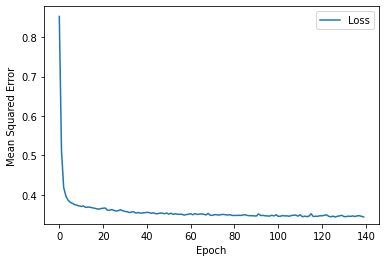


 Evaluate the new model against the test set:


3/3 [==============================] - 0s 6ms/step - loss: 0.4086 - mean_squared_error: 0.3767


[0.4086091220378876, 0.37673112750053406]

In [21]:
## HIDDERN FROM STUDENTS

# The following "solution" uses L2 regularization to bring training loss
# and test loss closer to each other. Many, many other solutions are possible.


def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""

  # Discard any pre-existing version of the model.
  model = None

  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model. 

  # Implement L2 regularization in the first hidden layer.
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                  name='Hidden1'))
  
  # Implement L2 regularization in the second hidden layer.
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                  name='Hidden2'))

  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model     

# Call the new create_model function and the other (unchanged) functions.

# The following variables are the hyperparameters.
learning_rate = 0.007
epochs = 140
batch_size = 1000

label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size) 